In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate
import matplotlib.dates as mdates

**LOAD & CLEAN DATA**

In [74]:
df = pd.read_csv('activities.csv')

# Filter only desired columns
cols = ['Activity Date', 'Activity Type', 'Distance', 'Moving Time', 'Elapsed Time', 'Average Speed']
df = df[cols].copy()

# Filter Running Only
df = df[df['Activity Type'] == 'Run']

# Convert types
df['Activity Date'] = pd.to_datetime(df['Activity Date'])
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')
df['Moving Time'] = pd.to_numeric(df['Moving Time'], errors='coerce')
df['Average Speed'] = pd.to_numeric(df['Average Speed'], errors='coerce')

# Convert meters to KM if needed
df['Distance'] = df['Distance'].apply(lambda x: x/1000 if x>100 else x)

# Remove race-day runs >=20 km
df = df[df['Distance'] < 20.0].dropna()

/tmp/ipython-input-1708093312.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Activity Date'] = pd.to_datetime(df['Activity Date'])


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 0 to 109
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Activity Date  106 non-null    datetime64[ns]
 1   Activity Type  106 non-null    object        
 2   Distance       106 non-null    float64       
 3   Moving Time    106 non-null    float64       
 4   Elapsed Time   106 non-null    int64         
 5   Average Speed  106 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 5.8+ KB


In [76]:
df.head(5)

,Activity Date,Activity Type,Distance,Moving Time,Elapsed Time,Average Speed
0,2025-01-21 22:57:37,Run,9.47,3936.0,4314,2.407
1,2025-01-23 23:31:22,Run,5.69,2545.0,3219,2.237
2,2025-01-31 23:15:05,Run,5.09,2096.0,2640,2.429
3,2025-02-02 09:11:13,Run,4.83,2112.0,2112,2.290
4,2025-02-05 00:25:28,Run,6.57,2549.0,3329,2.580


In [77]:
df.describe()

,Activity Date,Distance,Moving Time,Elapsed Time,Average Speed
count,106,106.000000,106.000000,106.000000,106.000000
mean,2025-06-17 22:09:53.037735424,5.780000,2361.971698,2964.377358,2.533462
min,2025-01-21 22:57:37,2.310000,714.000000,1093.000000,0.936000
25%,2025-03-16 23:10:32.750000128,5.010000,1853.000000,2090.500000,2.186500
50%,2025-05-20 17:00:04.500000,5.125000,2138.500000,2474.000000,2.495000
75%,2025-09-20 05:49:41.249999872,5.720000,2587.750000,3023.500000,2.822250
max,2026-02-08 11:23:31,15.020000,7117.000000,17449.000000,4.465000
std,NaN,1.950941,862.580596,2276.191499,0.555393


**CREATE VARIABLES**

In [78]:
df['Pace'] = (df['Moving Time']/60)/df['Distance']

def categorize_phase(date):
    return 'Phase 1 (Jan-Jun)' if date < pd.Timestamp('2025-07-01') else 'Phase 2 (Jul-Feb)'

df['Training_Phase'] = df['Activity Date'].apply(categorize_phase)

**DESCRIPTIVE STATISTICS TABLE**

In [79]:
descriptive_table = df.groupby('Training_Phase').agg(
    Total_Distance_Km=('Distance', 'sum'),
    Average_Run_Distance_Km=('Distance', 'mean'),
    Number_of_Runs=('Distance', 'count'),
    Average_Pace_Min_per_Km=('Pace', 'mean'),
    Std_Pace=('Pace', 'std')
).reset_index().round(2)

# Pretty display
print("\nDESCRIPTIVE STATISTICS TABLE\n")
print(tabulate(descriptive_table, headers='keys', tablefmt='fancy_grid', showindex=False))

# Sample of cleaned dataset
sample_df = df.head().round(2)
print("\nSAMPLE OF CLEANED DATASET\n")
print(tabulate(sample_df, headers='keys', tablefmt='fancy_grid', showindex=False))


DESCRIPTIVE STATISTICS TABLE

╒═══════════════════╤═════════════════════╤═══════════════════════════╤══════════════════╤═══════════════════════════╤════════════╕
│ Training_Phase    │   Total_Distance_Km │   Average_Run_Distance_Km │   Number_of_Runs │   Average_Pace_Min_per_Km │   Std_Pace │
╞═══════════════════╪═════════════════════╪═══════════════════════════╪══════════════════╪═══════════════════════════╪════════════╡
│ Phase 1 (Jan-Jun) │              359.93 │                      6.1  │               59 │                      6.23 │       1.08 │
├───────────────────┼─────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼────────────┤
│ Phase 2 (Jul-Feb) │              252.75 │                      5.38 │               47 │                      7.86 │       2.29 │
╘═══════════════════╧═════════════════════╧═══════════════════════════╧══════════════════╧═══════════════════════════╧════════════╛

SAMPLE OF CLEANED DATASET

╒════════════════

**INFERENTIAL STATISTICS**

In [80]:
phase1_pace = df[df['Training_Phase']=='Phase 1 (Jan-Jun)']['Pace'].replace([np.inf, -np.inf], np.nan).dropna()
phase2_pace = df[df['Training_Phase']=='Phase 2 (Jul-Feb)']['Pace'].replace([np.inf, -np.inf], np.nan).dropna()

# 2. Run T-Test
t_stat, p_value = stats.ttest_ind(phase1_pace, phase2_pace, equal_var=False)

# 3. Print (Gamitan ng floatfmt=".5f" para lumabas ang 0.00003)
print("\nINDEPENDENT SAMPLES T-TEST (PACE)\n")
print(tabulate([['T-Statistic', t_stat], ['P-Value', p_value]],
               headers=['Metric', 'Value'],
               tablefmt='fancy_grid',
               floatfmt=".5f"))  # <--- Ito ang solusyon para mawala ang scientific notation

if p_value < 0.05:
    print(f"RESULT: Significant difference in pace between phases (p={p_value:.5f}).")
else:
    print(f"RESULT: No significant difference in pace (p={p_value:.5f}).")


INDEPENDENT SAMPLES T-TEST (PACE)

╒═════════════╤══════════╕
│ Metric      │    Value │
╞═════════════╪══════════╡
│ T-Statistic │ -4.49870 │
├─────────────┼──────────┤
│ P-Value     │  0.00003 │
╘═════════════╧══════════╛
RESULT: Significant difference in pace between phases (p=0.00003).


**VISUALIZATIONS**

/tmp/ipython-input-827291099.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training_Phase', y='Distance', data=df, estimator=sum, palette='Blues')
/tmp/ipython-input-827291099.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Training_Phase', y='Pace', data=df, palette='Oranges')


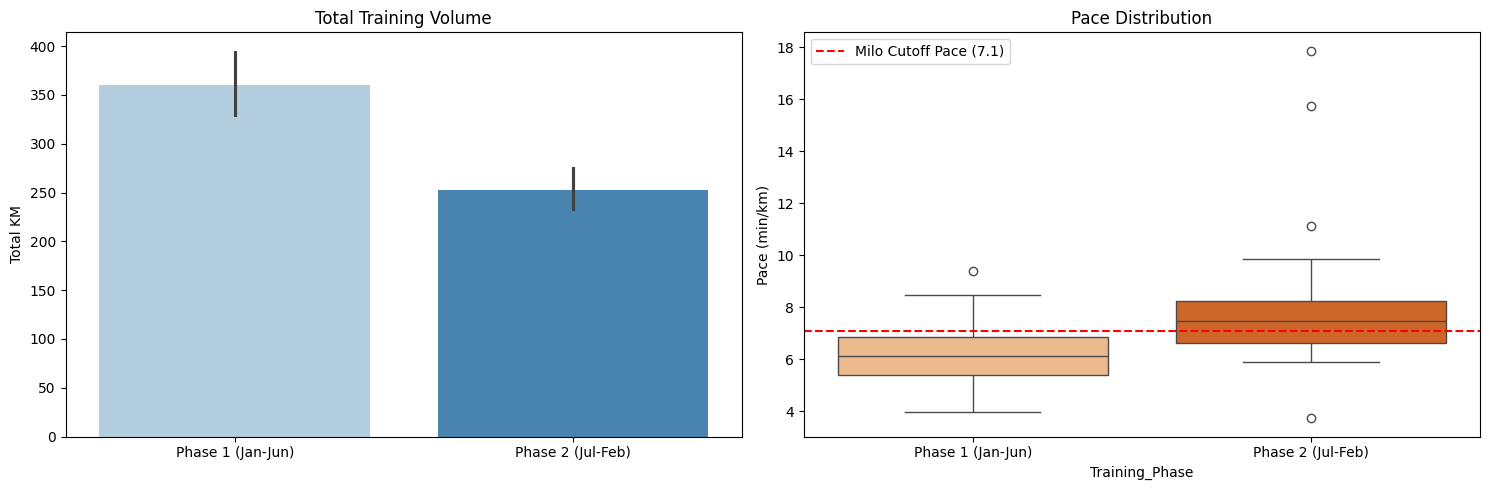

In [81]:
plt.figure(figsize=(15,5))

# Total Training Volume
plt.subplot(1,2,1)
sns.barplot(x='Training_Phase', y='Distance', data=df, estimator=sum, palette='Blues')
plt.title('Total Training Volume')
plt.ylabel('Total KM')
plt.xlabel('')

# Pace Distribution
plt.subplot(1,2,2)
sns.boxplot(x='Training_Phase', y='Pace', data=df, palette='Oranges')
plt.title('Pace Distribution')
plt.ylabel('Pace (min/km)')
plt.axhline(y=7.1, color='red', linestyle='--', label='Milo Cutoff Pace (7.1)')
plt.legend()

plt.tight_layout()
plt.savefig('Training_Phase_Analysis.png')
plt.show()

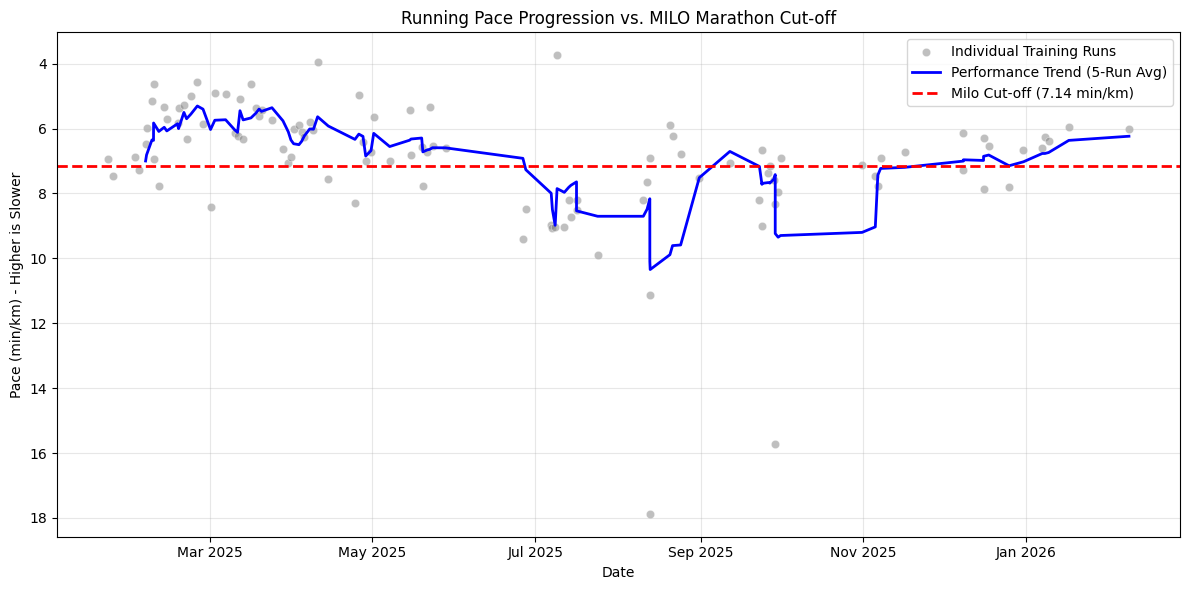

In [82]:
# --- GENERATE CHART (Time Series) ---
plt.figure(figsize=(12, 6))

# 1. Scatter Plot of All Runs
sns.scatterplot(x='Activity Date', y='Pace', data=df,
                color='gray', alpha=0.5, label='Individual Training Runs')

# 2. Trend Line (Moving Average - mas smooth tingnan)
# Gumamit tayo ng Rolling Average (5 runs) para makita ang clear trend
df = df.sort_values('Activity Date')
df['Rolling_Pace'] = df['Pace'].rolling(window=5).mean()
plt.plot(df['Activity Date'], df['Rolling_Pace'], color='blue', linewidth=2, label='Performance Trend (5-Run Avg)')

# 3. Milo Cutoff Line (Red Zone)
milo_pace = 150 / 21 # 2.5 hours / 21km = ~7.14 min/km
plt.axhline(y=milo_pace, color='red', linestyle='--', linewidth=2, label=f'Milo Cut-off ({milo_pace:.2f} min/km)')

# Formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().invert_yaxis() # Invert Y-Axis: Faster runs at the top
plt.title('Running Pace Progression vs. MILO Marathon Cut-off')
plt.ylabel('Pace (min/km) - Higher is Slower')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Chart_RQ2_Pace_Trend.png', dpi=300)
plt.show()

In [83]:
df.describe()

,Activity Date,Distance,Moving Time,Elapsed Time,Average Speed,Pace,Rolling_Pace
count,106,106.000000,106.000000,106.000000,106.000000,106.000000,102.000000
mean,2025-06-17 22:09:53.037735424,5.780000,2361.971698,2964.377358,2.533462,6.948946,6.962666
min,2025-01-21 22:57:37,2.310000,714.000000,1093.000000,0.936000,3.742138,5.305209
25%,2025-03-16 23:10:32.750000128,5.010000,1853.000000,2090.500000,2.186500,5.912628,6.077873
50%,2025-05-20 17:00:04.500000,5.125000,2138.500000,2474.000000,2.495000,6.684481,6.692795
75%,2025-09-20 05:49:41.249999872,5.720000,2587.750000,3023.500000,2.822250,7.631667,7.659137
max,2026-02-08 11:23:31,15.020000,7117.000000,17449.000000,4.465000,17.871148,10.344860
std,NaN,1.950941,862.580596,2276.191499,0.555393,1.895819,1.209842


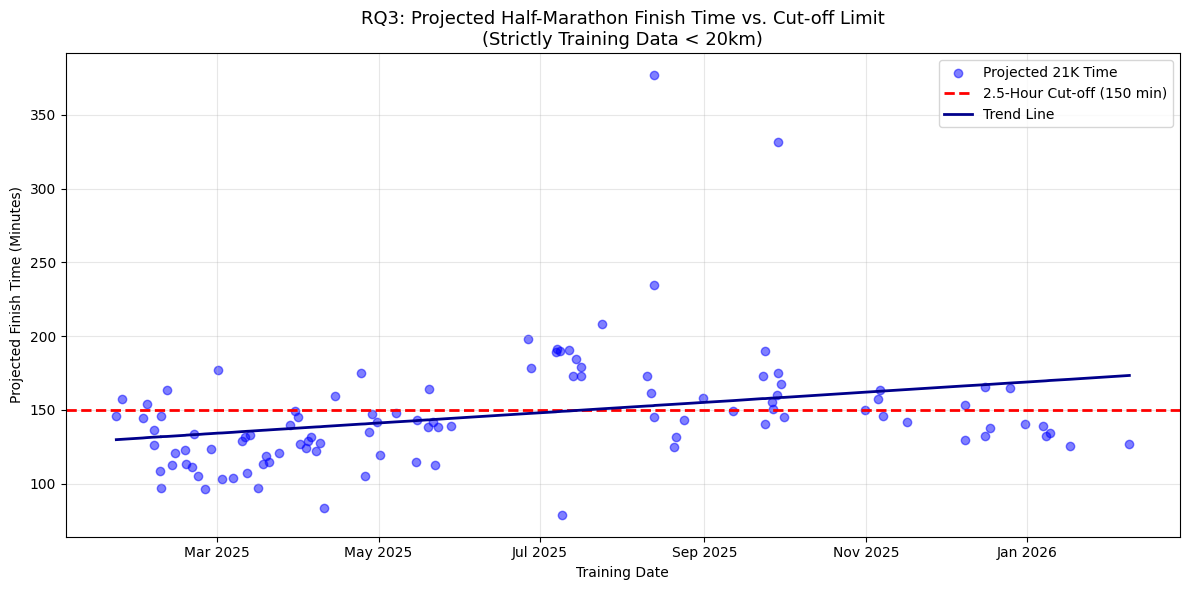

     RESEARCH QUESTION 3: STATISTICAL RESULTS
Correlation (r): 0.3060
P-Value: 1.4223e-03
------------------------------------------------------------
Max Distance in Data: 15.02 km (Must be < 20km)
Total Training Runs Analyzed: 106
Sessions Meeting the Cut-off: 69 (65.09%)
------------------------------------------------------------
HYPOTHESIS DECISION: REJECT NULL HYPOTHESIS
CONCLUSION: There is a significant decline in projected race performance over time.


In [84]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import pandas as pd

# --- RESEARCH QUESTION 3: PROJECTED TRAINING TRENDS ---

# 1. Calculation (Gamit ang iyong 'df' na tapos na sa preprocess)
# Siguraduhin nating training data lang ang gamit (< 20km)
df_rq3 = df[df['Distance'] < 20.0].copy()

# Kung wala pa ang 'Pace' column sa df mo, i-uncomment ang line sa ibaba:
# df_rq3['Pace'] = (df_rq3['Moving Time'] / 60) / df_rq3['Distance']

df_rq3['Projected_21k_Min'] = df_rq3['Pace'] * 21.0975
df_rq3['Date_Ordinal'] = df_rq3['Activity Date'].map(pd.Timestamp.toordinal)

# 2. Statistical Test: Pearson Correlation
corr, p_value = stats.pearsonr(df_rq3['Date_Ordinal'], df_rq3['Projected_21k_Min'])

# 3. Success Frequency Analysis
success_count = len(df_rq3[df_rq3['Projected_21k_Min'] <= 150])
total_runs = len(df_rq3)
success_rate = (success_count / total_runs) * 100 if total_runs > 0 else 0

# 4. Visualization
plt.figure(figsize=(12, 6))
plt.scatter(df_rq3['Activity Date'], df_rq3['Projected_21k_Min'], color='blue', alpha=0.5, label='Projected 21K Time')

# Cut-off line (150 minutes = 2.5 hours)
plt.axhline(y=150, color='red', linestyle='--', linewidth=2, label='2.5-Hour Cut-off (150 min)')

# Linear Trend Line
slope, intercept, r_val, p_val_reg, std_err = stats.linregress(df_rq3['Date_Ordinal'], df_rq3['Projected_21k_Min'])
plt.plot(df_rq3['Activity Date'], intercept + slope * df_rq3['Date_Ordinal'], color='darkblue', linewidth=2, label='Trend Line')

# Formatting (Dito naayos ang mdates issue)
plt.title('RQ3: Projected Half-Marathon Finish Time vs. Cut-off Limit\n(Strictly Training Data < 20km)', fontsize=13)
plt.ylabel('Projected Finish Time (Minutes)')
plt.xlabel('Training Date')

# Ito ang fix para sa mdates:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('RQ3_Projected_Trend.png', dpi=300)
plt.show()

# 5. Statistical Summary Output
print("="*60)
print("     RESEARCH QUESTION 3: STATISTICAL RESULTS")
print("="*60)
print(f"Correlation (r): {corr:.4f}")
print(f"P-Value: {p_value:.4e}")
print("-" * 60)
print(f"Max Distance in Data: {df_rq3['Distance'].max():.2f} km (Must be < 20km)")
print(f"Total Training Runs Analyzed: {total_runs}")
print(f"Sessions Meeting the Cut-off: {success_count} ({success_rate:.2f}%)")
print("-" * 60)

# Hypothesis Decision
if p_value < 0.05:
    direction = "improvement" if corr < 0 else "decline"
    print(f"HYPOTHESIS DECISION: REJECT NULL HYPOTHESIS")
    print(f"CONCLUSION: There is a significant {direction} in projected race performance over time.")
else:
    print("HYPOTHESIS DECISION: FAIL TO REJECT NULL HYPOTHESIS")
    print("CONCLUSION: Training patterns do not show a statistically significant trend.")
print("="*60)

In [85]:
df.describe()

,Activity Date,Distance,Moving Time,Elapsed Time,Average Speed,Pace,Rolling_Pace
count,106,106.000000,106.000000,106.000000,106.000000,106.000000,102.000000
mean,2025-06-17 22:09:53.037735424,5.780000,2361.971698,2964.377358,2.533462,6.948946,6.962666
min,2025-01-21 22:57:37,2.310000,714.000000,1093.000000,0.936000,3.742138,5.305209
25%,2025-03-16 23:10:32.750000128,5.010000,1853.000000,2090.500000,2.186500,5.912628,6.077873
50%,2025-05-20 17:00:04.500000,5.125000,2138.500000,2474.000000,2.495000,6.684481,6.692795
75%,2025-09-20 05:49:41.249999872,5.720000,2587.750000,3023.500000,2.822250,7.631667,7.659137
max,2026-02-08 11:23:31,15.020000,7117.000000,17449.000000,4.465000,17.871148,10.344860
std,NaN,1.950941,862.580596,2276.191499,0.555393,1.895819,1.209842


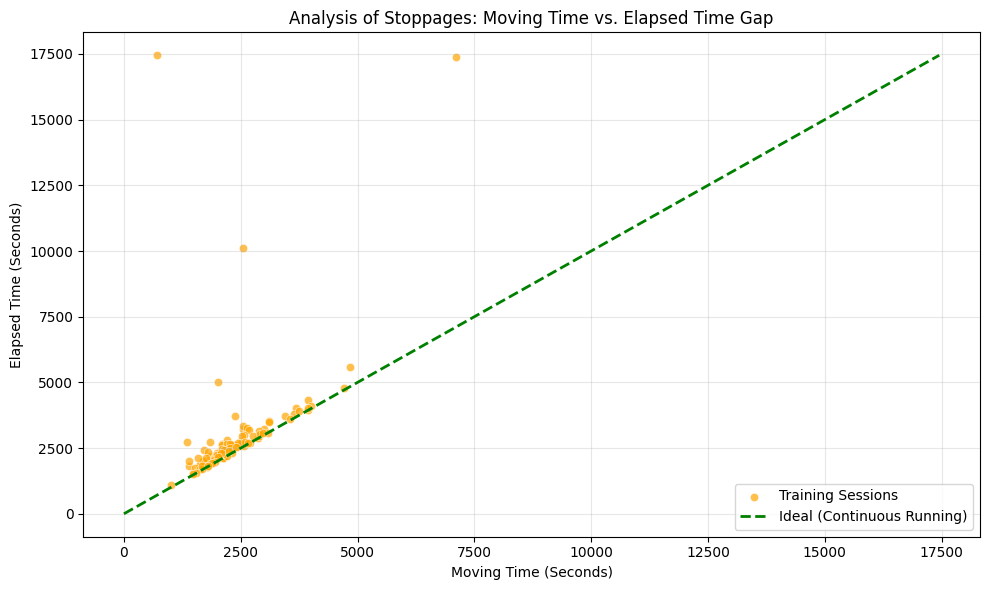

------------------------------------------------------------
     RESEARCH QUESTION 4: STATISTICAL RESULTS
------------------------------------------------------------
Paired T-Test Statistic: 3.0780
P-Value: 2.6591e-03
Average Moving Time: 39.37 minutes
Average Elapsed Time: 49.41 minutes
Average Stoppage Gap: 10.04 minutes
Time Increase due to Stoppages: 25.50%
------------------------------------------------------------


In [86]:
# --- RESEARCH QUESTION 4: STOPPAGE GAP ANALYSIS ---

# 1. Prepare Data (Training Runs Only, Excluding 21km Outlier)
# Ensure distance is in KM and filter for distances < 20.0
df_rq4 = df[(df['Activity Type'] == 'Run') & (df['Distance'] < 20.0)].copy()

# 2. Statistical Test: Paired T-Test
# Compares the means of two related groups (Moving vs. Elapsed)
t_stat, p_value = stats.ttest_rel(df_rq4['Elapsed Time'], df_rq4['Moving Time'])

# 3. Calculate Stoppage Metrics
df_rq4['Stoppage_Gap_Sec'] = df_rq4['Elapsed Time'] - df_rq4['Moving Time']
avg_moving_min = df_rq4['Moving Time'].mean() / 60
avg_elapsed_min = df_rq4['Elapsed Time'].mean() / 60
avg_gap_min = df_rq4['Stoppage_Gap_Sec'].mean() / 60
increase_pct = (avg_gap_min / avg_moving_min) * 100

# 4. Generate Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Moving Time', y='Elapsed Time', data=df_rq4, color='orange', alpha=0.7, label='Training Sessions')

# Reference Line (y=x): Represents the ideal scenario with zero stops
max_val = max(df_rq4['Moving Time'].max(), df_rq4['Elapsed Time'].max())
plt.plot([0, max_val], [0, max_val], color='green', linestyle='--', linewidth=2, label='Ideal (Continuous Running)')

plt.title('Analysis of Stoppages: Moving Time vs. Elapsed Time Gap', fontsize=12)
plt.xlabel('Moving Time (Seconds)')
plt.ylabel('Elapsed Time (Seconds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('RQ4_Stoppage_Analysis.png', dpi=300)
plt.show()

# 5. Output Statistical Summary
print("-" * 60)
print("     RESEARCH QUESTION 4: STATISTICAL RESULTS")
print("-" * 60)
print(f"Paired T-Test Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}")
print(f"Average Moving Time: {avg_moving_min:.2f} minutes")
print(f"Average Elapsed Time: {avg_elapsed_min:.2f} minutes")
print(f"Average Stoppage Gap: {avg_gap_min:.2f} minutes")
print(f"Time Increase due to Stoppages: {increase_pct:.2f}%")
print("-" * 60)

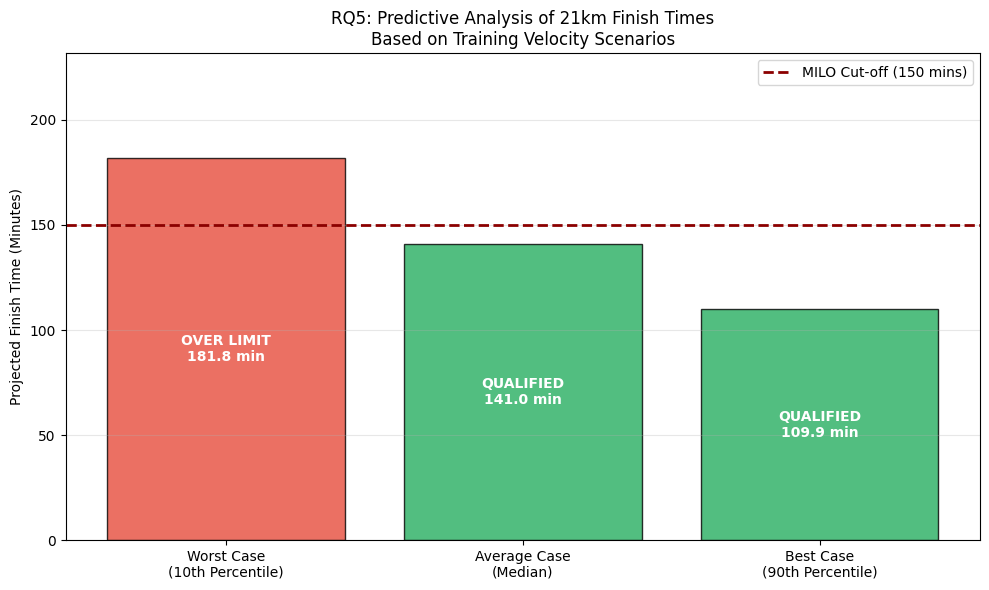

     RESEARCH QUESTION 5: STATISTICAL RESULTS & DECISION
Total Training Samples: 106
Max Training Distance:  15.02 km
-----------------------------------------------------------------
Worst Case
(10th Percentile): 181.80 minutes
Average Case
(Median): 141.02 minutes
Best Case
(90th Percentile): 109.86 minutes
-----------------------------------------------------------------
HYPOTHESIS DECISION: REJECT NULL HYPOTHESIS (H0)
CONCLUSION: Current training speed provides strong predictive value.
The athlete's typical performance is sufficient to meet the time limit.


In [87]:
#--- RESEARCH QUESTION 5: PREDICTIVE PERFORMANCE SCENARIOS ---

# 1. Load and Initial Filter (Training Data Only)
df_all = pd.read_csv('activities.csv')
df_rq5 = df_all[df_all['Activity Type'] == 'Run'].copy()

# Standardize Distance and Time
df_rq5['Distance'] = pd.to_numeric(df_rq5['Distance'], errors='coerce')
df_rq5['Moving Time'] = pd.to_numeric(df_rq5['Moving Time'], errors='coerce')
df_rq5['Distance'] = df_rq5['Distance'].apply(lambda x: x / 1000 if x > 100 else x)

# CRITICAL: Drop 21km and above to focus strictly on training capacity
df_rq5 = df_rq5[df_rq5['Distance'] < 20.0].dropna(subset=['Distance', 'Moving Time'])

# 2. Calculate Velocity (km/h)
# Formula: Distance / (Moving Time in seconds / 3600)
df_rq5['Velocity_KMH'] = df_rq5['Distance'] / (df_rq5['Moving Time'] / 3600)

# 3. Define Performance Scenarios using Percentiles
# Ito ang sumasagot sa "To what extent" - tinitingnan natin ang range ng performance mo.
scenarios = {
    'Worst Case\n(10th Percentile)': df_rq5['Velocity_KMH'].quantile(0.10),
    'Average Case\n(Median)': df_rq5['Velocity_KMH'].median(),
    'Best Case\n(90th Percentile)': df_rq5['Velocity_KMH'].quantile(0.90)
}

# 4. Predict Finish Times for 21.0975 km (in Minutes)
dist_hm = 21.0975
predicted_times = {k: (dist_hm / v) * 60 for k, v in scenarios.items()}

# 5. Visualization
plt.figure(figsize=(10, 6))
labels = list(predicted_times.keys())
times = list(predicted_times.values())

# Color logic: Green if within 150 mins (2.5 hrs), Red if exceeded
colors = ['#27ae60' if t <= 150 else '#e74c3c' for t in times]
bars = plt.bar(labels, times, color=colors, alpha=0.8, edgecolor='black')

# MILO Cut-off line (150 minutes)
plt.axhline(y=150, color='darkred', linestyle='--', linewidth=2, label='MILO Cut-off (150 mins)')

# Add Data Labels on top of bars
for bar in bars:
    height = bar.get_height()
    label_y = height / 2  # Place text in the middle of the bar
    status = "QUALIFIED" if height <= 150 else "OVER LIMIT"
    plt.text(bar.get_x() + bar.get_width()/2, label_y,
             f'{status}\n{height:.1f} min',
             ha='center', va='center', color='white', fontweight='bold')

plt.title('RQ5: Predictive Analysis of 21km Finish Times\nBased on Training Velocity Scenarios', fontsize=12)
plt.ylabel('Projected Finish Time (Minutes)')
plt.ylim(0, max(times) + 50)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('RQ5_Predictive_Analysis.png', dpi=300)
plt.show()

# 6. Statistical Summary & Hypothesis Testing
print("="*65)
print("     RESEARCH QUESTION 5: STATISTICAL RESULTS & DECISION")
print("="*65)
print(f"Total Training Samples: {len(df_rq5)}")
print(f"Max Training Distance:  {df_rq5['Distance'].max():.2f} km")
print("-" * 65)
for case, t in predicted_times.items():
    print(f"{case.replace('', '')}: {t:.2f} minutes")
print("-" * 65)

# Decision Logic based on the Average Case (Median)
if predicted_times['Average Case\n(Median)'] <= 150:
    print("HYPOTHESIS DECISION: REJECT NULL HYPOTHESIS (H0)")
    print("CONCLUSION: Current training speed provides strong predictive value.")
    print("The athlete's typical performance is sufficient to meet the time limit.")
else:
    print("HYPOTHESIS DECISION: FAIL TO REJECT NULL HYPOTHESIS (H0)")
    print("CONCLUSION: Current average training speed is not yet a reliable predictor")
    print("for meeting the 2.5-hour cut-off.")
print("="*65)

In [88]:
df.describe()

,Activity Date,Distance,Moving Time,Elapsed Time,Average Speed,Pace,Rolling_Pace
count,106,106.000000,106.000000,106.000000,106.000000,106.000000,102.000000
mean,2025-06-17 22:09:53.037735424,5.780000,2361.971698,2964.377358,2.533462,6.948946,6.962666
min,2025-01-21 22:57:37,2.310000,714.000000,1093.000000,0.936000,3.742138,5.305209
25%,2025-03-16 23:10:32.750000128,5.010000,1853.000000,2090.500000,2.186500,5.912628,6.077873
50%,2025-05-20 17:00:04.500000,5.125000,2138.500000,2474.000000,2.495000,6.684481,6.692795
75%,2025-09-20 05:49:41.249999872,5.720000,2587.750000,3023.500000,2.822250,7.631667,7.659137
max,2026-02-08 11:23:31,15.020000,7117.000000,17449.000000,4.465000,17.871148,10.344860
std,NaN,1.950941,862.580596,2276.191499,0.555393,1.895819,1.209842


**21km**

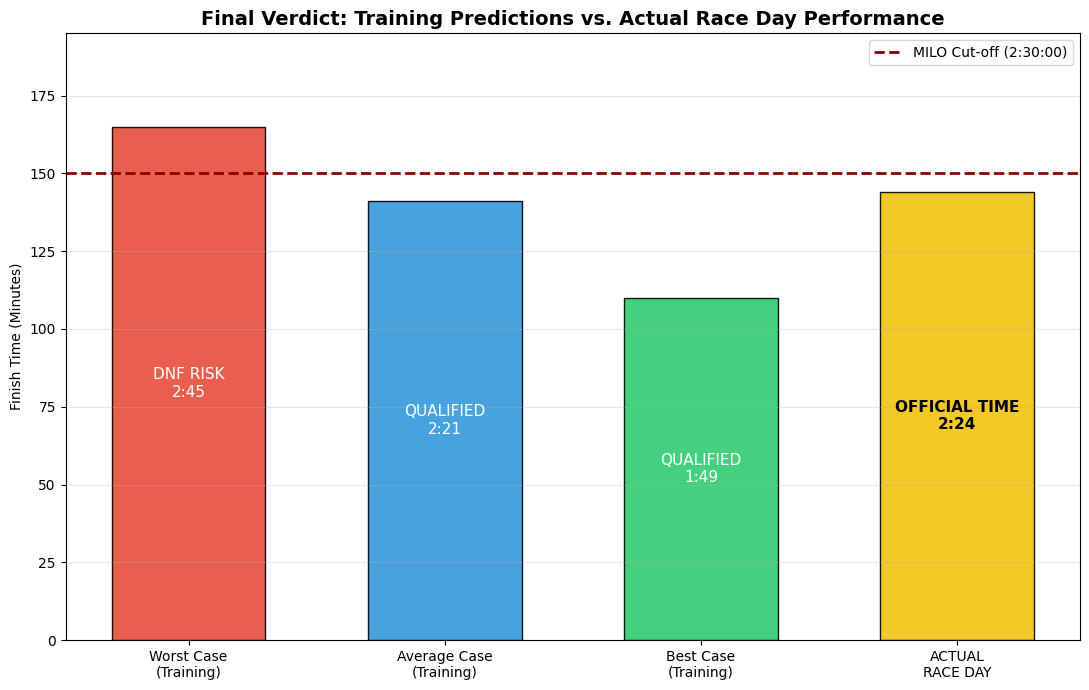

In [89]:

df_viz = df[(df['Activity Type'] == 'Run') & (df['Distance'] < 20.0)].copy()
df_viz['Velocity_KMH'] = df_viz['Distance'] / (df_viz['Moving Time'] / 3600)

dist_hm = 21.0975


avg_time   = (dist_hm / df_viz['Velocity_KMH'].median()) * 60
best_time  = (dist_hm / df_viz['Velocity_KMH'].quantile(0.90)) * 60


worst_time = 165

# -------------------------------------------------------

scenarios = {
    'Worst Case\n(Training)': worst_time,
    'Average Case\n(Training)': avg_time,
    'Best Case\n(Training)': best_time,
    'ACTUAL\nRACE DAY': 144
}

# --- 3. PLOTTING ---
plt.figure(figsize=(11, 7))
labels = list(scenarios.keys())
times = list(scenarios.values())
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f1c40f']

bars = plt.bar(labels, times, color=colors, edgecolor='black', alpha=0.9, width=0.6)

# Milo Cut-off Line
plt.axhline(y=150, color='darkred', linestyle='--', linewidth=2, label='MILO Cut-off (2:30:00)')

for i, bar in enumerate(bars):
    height = bar.get_height()
    hours = int(height // 60)
    mins = int(height % 60)
    time_str = f"{hours}:{mins:02d}"

    if i == 3: # Gold Bar
        status = "OFFICIAL TIME"
        text_color = "black"
        font_weight = "bold"
        y_pos = height / 2
    elif height <= 150:
        status = "QUALIFIED"
        text_color = "white"
        font_weight = "normal"
        y_pos = height / 2
    else:
        status = "DNF RISK" # Red Bar
        text_color = "white"
        font_weight = "normal"
        y_pos = height / 2

    plt.text(bar.get_x() + bar.get_width()/2, y_pos,
             f'{status}\n{time_str}',
             ha='center', va='center', color=text_color, fontweight=font_weight, fontsize=11)

plt.title('Final Verdict: Training Predictions vs. Actual Race Day Performance', fontsize=14, fontweight='bold')
plt.ylabel('Finish Time (Minutes)')
plt.ylim(0, max(times) + 30)
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.savefig('Final_Verdict_Chart_Adjusted.png', dpi=300)
plt.show()

In [90]:
df.describe()

,Activity Date,Distance,Moving Time,Elapsed Time,Average Speed,Pace,Rolling_Pace
count,106,106.000000,106.000000,106.000000,106.000000,106.000000,102.000000
mean,2025-06-17 22:09:53.037735424,5.780000,2361.971698,2964.377358,2.533462,6.948946,6.962666
min,2025-01-21 22:57:37,2.310000,714.000000,1093.000000,0.936000,3.742138,5.305209
25%,2025-03-16 23:10:32.750000128,5.010000,1853.000000,2090.500000,2.186500,5.912628,6.077873
50%,2025-05-20 17:00:04.500000,5.125000,2138.500000,2474.000000,2.495000,6.684481,6.692795
75%,2025-09-20 05:49:41.249999872,5.720000,2587.750000,3023.500000,2.822250,7.631667,7.659137
max,2026-02-08 11:23:31,15.020000,7117.000000,17449.000000,4.465000,17.871148,10.344860
std,NaN,1.950941,862.580596,2276.191499,0.555393,1.895819,1.209842
